In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [2]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [3]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Initial Gradient Boosting model

Initial Gradient Boosting model used to test pipline and estimate the baseline accuracy. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) with automatically determined categories.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("ordinal", OrdinalEncoder())])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ],
    sparse_threshold=0
)

model = Pipeline([('prep', preprocessor), ('regr', HistGradientBoostingRegressor())])
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr', HistGradientBoostingRegressor())])

Function to print model prediction RMSE and R2

In [16]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets.

In [17]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.558  R2= 0.625 
Test: RMSE= 1.621  R2= 0.592


## Randomized Search CV with Hist Gradient Boosting

We used Randomized Search cross validation to tune Hist version of GB model hyparameters. Hist version used to speed the search.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import HistGradientBoostingRegressor
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', HistGradientBoostingRegressor())])

grid = {
        'regr__learning_rate': np.linspace(0.05,  0.2,  4),
        'regr__max_iter': np.arange(200, 500, 50, dtype=int),
        'regr__min_samples_leaf': np.arange(10, 25, 5, dtype=int),
        'regr__max_depth':np.arange(5, 15, dtype=int)
        }
search = RandomizedSearchCV(model, grid, scoring='neg_root_mean_squared_error', n_iter = 50, cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)

results_pd = pd.DataFrame(results.cv_results_)
results_pd.filter(regex='rank|regr|mean_test_score|std_test_score',axis=1).sort_values('rank_test_score').head().T

,4,21,11,2,13
param_regr__min_samples_leaf,20,20,10,20,15
param_regr__max_iter,300,300,350,200,200
param_regr__max_depth,11,7,7,9,6
param_regr__learning_rate,0.15,0.1,0.15,0.1,0.1
mean_test_score,-1.669551,-1.672561,-1.673124,-1.673312,-1.673454
std_test_score,0.031515,0.029473,0.02837,0.030771,0.0304
rank_test_score,1,2,3,4,5


In [19]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 HistGradientBoostingRegressor(learning_rate=0.15000000000000002,
                                               max_depth=11, max_iter=300))])

In [20]:
print_model_rmse_r2(best_model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.515  R2= 0.646 
Test: RMSE= 1.618  R2= 0.594


Variability of parameter values is large with small difference in loss for five best iterations, further search would not likely to greatly reduce loss. Performance gain over untuned initial model is significant. The model with parameters from best iteration will be used for further analysis.

## Feature importance 

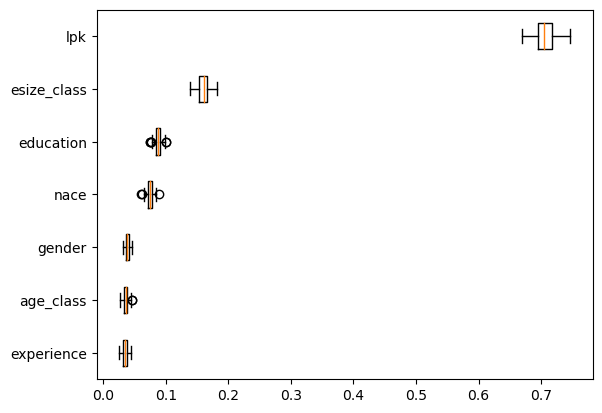

In [21]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_test, y_test,  n_repeats=100,  random_state=0)
importance_order = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.boxplot(
    perm_importance.importances[importance_order].T,
    vert=False,
    labels=np.array(X_test.columns)[importance_order],
);

By far the most important feature is profession (lpk) followed by company size and education. The economic sector, gender, age and experience are less important. Feature immportance results might be affected by large cardinality of lpk and nace.

# Model (Pipline) Serialization 

In [22]:
import joblib
joblib.dump(best_model, './Models/GRBoost_model.joblib')

['./Models/GRBoost_model.joblib']